On souhaite classer des images de cellules sanguines en utilisant un CNN. Les images sont groupées en 11 classes :

- **BA :** BAsophiles
- **BNE :** NEutrophiles de Bande
- **EO :** EOsinophiles
- **ERB :** ERythroBlastes
- **LY :** LYmphocytes
- **MMY :** MétaMYélocytes
- **MO :** MOnocytes
- **MY :** MYélocytes
- **PLT :** PLaqueTtes
- **PMY :** Promyélocytes
- **SNE :** NEutrophiles Segmentés

L'approche choisie est le **Transfer Learning** : on utilise le modèle **EfficientNet B3** et les poids optimisés pour ImageNet. Les données utilisées sont celles du dataset **"Barcelone"**.

# Import des modules. Connexion au Drive.

In [1]:
## Gives access to the Drive
from google.colab import drive
drive.mount('/content/drive')

## Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

import sys, os
from pathlib import Path
import shutil
import glob
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import EfficientNetB3

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN, EarlyStopping

from tensorflow.keras.utils import Sequence
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append('/content/drive/MyDrive/Leukopy')
import leukopy_lib as leuko
from importlib import reload

reload(leuko)

## GPU status verification
tf.test.gpu_device_name()

## GPU type verification
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Wed Nov 10 08:04:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                              

# Import des données

In [ ]:
## Need to copy all the files on the local computer
!cp -r "/content/drive/MyDrive/Leukopy/data/main_dataset.zip" .
!unzip main_dataset.zip

## Create the original dataframes 
path = Path('/content/main_dataset/')

df_train = leuko.generate_images_df(path/'training_set')
df_test = leuko.generate_images_df(path/'testing_set')
df_valid = leuko.generate_images_df(path/'validation_set')

On élimine le label "BL" du dataset : trop peu d'images, trop différentes du reste de Barcelone.

In [3]:
df_train = df_train[df_train["label"] != "BL"]
df_test = df_test[df_test["label"] != "BL"]
df_valid = df_valid[df_valid["label"] != "BL"]

n_classes = df_train["label"].nunique()

On découpe les données en une série de batchs de 32 images. Les images sont redimensionnées (300 * 300 pixels) et on programme une augmentation de données (rotation, symétries axiales). Le preprocessing spécifique à ce modèle est géré par une couche du modèle : il n'y a donc pas de fonction preprocess_input à intégrer dans ImageDataGenerator.

In [4]:
batch_size = 32
img_height  = 300
img_width = 300

# EfficientNet normalizes the pictures. Data augmentation : rotation, zoom, brightness => only on training set
train_generator = ImageDataGenerator(rotation_range = 90,
                                     horizontal_flip = True, 
                                     vertical_flip = True)
valid_generator = ImageDataGenerator()
test_generator = ImageDataGenerator()

# Resize pictures, batchs from dataframe
training_set = train_generator.flow_from_dataframe(df_train, 
                                                   directory = None, # utilise x_col
                                                   x_col = 'img_path', 
                                                   y_col = 'label',
                                                   target_size = (img_height, img_width), 
                                                   color_mode = 'rgb',
                                                   classes = None,   # utilise y_col
                                                   class_mode = 'categorical', 
                                                   batch_size = batch_size,
                                                   shuffle = True)

validation_set = valid_generator.flow_from_dataframe(df_valid, 
                                                     directory = None, # utilise x_col
                                                     x_col = 'img_path', 
                                                     y_col = 'label',
                                                     target_size = (img_height, img_width), 
                                                     color_mode = 'rgb',
                                                     classes = None,   # utilise y_col
                                                     class_mode = 'categorical', 
                                                     batch_size = batch_size, 
                                                     shuffle = True)

testing_set = test_generator.flow_from_dataframe(df_test, 
                                                 directory = None, # utilise x_col
                                                 x_col = 'img_path', 
                                                 y_col = 'label',
                                                 target_size = (img_height, img_width),
                                                 color_mode = 'rgb',
                                                 classes = None,   # utilise y_col
                                                 class_mode = 'categorical', 
                                                 batch_size = batch_size, 
                                                 shuffle = False)

# Labels/Index connection :
label_map = training_set.class_indices
print('Train :', training_set.class_indices)
print('Valid :', validation_set.class_indices)
print('Test  :', testing_set.class_indices)

Found 12677 validated image filenames belonging to 11 classes.
Found 1730 validated image filenames belonging to 11 classes.
Found 2544 validated image filenames belonging to 11 classes.
Train : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Valid : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}
Test  : {'BA': 0, 'BNE': 1, 'EO': 2, 'ERB': 3, 'LY': 4, 'MMY': 5, 'MO': 6, 'MY': 7, 'PLT': 8, 'PMY': 9, 'SNE': 10}


# Construction du modèle B3

On crée une fonction calculant des poids, permettant de pénaliser l'erreur commise sur les classes les moins représentées du dataset. On espère ainsi compenser partiellement le déséquilibre du dataset.


In [5]:
def compute_weights(training_set):
  counter = Counter(training_set.classes)                       
  class_weights = {class_id : (1/num_images)*float(sum(counter.values()))/2 for class_id, num_images in counter.items()}
  return class_weights

On connecte le modèle EfficientNet (modèle gelé) à un ensemble de 3 couches Denses (1280, 640, 11), séparées par une couche de Dropout pour réduire le surapprentissage. La couche Dense de sortie est activée par la fonction Softmax pour calculer des probabilités d'appartenance aux classes.

On utilise Adam pour gérer la descente de gradient et on démarre avec un taux d'apprentissage égal à 10e-3.


In [ ]:
# Model (Functional API)
inputs = layers.Input(shape = (img_height,img_width,3))
base_model = EfficientNetB3(include_top = False,
                           weights = 'imagenet',
                           input_shape = (img_height,img_width,3),
                           input_tensor = inputs,
                           pooling = 'avg')
base_output = base_model.output      # Cette écriture permet d'avoir les couches de "base_model" au même niveau que les couches suivantes (voir model.summary())=> Grad-CAM peut fonctionner
x = layers.Dense(units = 1280, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 640, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax', name = 'final_softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Freeze EfficientNet
base_model.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

# Entraînement

In [ ]:
# Callbacks
TON = TerminateOnNaN()

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 3, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(method = 3)

## Training :
epochs = 30
history = model.fit(x = training_set, 
                    epochs = epochs,
                    callbacks = callbacks_list, 
                    validation_data = validation_set, 
                    class_weight = class_weights)

Epoch 1/30
397/397 [==============================] - 297s 661ms/step - loss: 6.2341 - accuracy: 0.6107 - val_loss: 0.6430 - val_accuracy: 0.7705
Epoch 2/30
397/397 [==============================] - 258s 649ms/step - loss: 4.2811 - accuracy: 0.7328 - val_loss: 0.6042 - val_accuracy: 0.7827
Epoch 3/30
397/397 [==============================] - 257s 647ms/step - loss: 3.9275 - accuracy: 0.7581 - val_loss: 0.5668 - val_accuracy: 0.7913
Epoch 4/30
397/397 [==============================] - 260s 656ms/step - loss: 3.6755 - accuracy: 0.7790 - val_loss: 0.5406 - val_accuracy: 0.7798
Epoch 5/30
397/397 [==============================] - 258s 651ms/step - loss: 3.5046 - accuracy: 0.7819 - val_loss: 0.5054 - val_accuracy: 0.8098
Epoch 6/30
397/397 [==============================] - 258s 650ms/step - loss: 3.3310 - accuracy: 0.7955 - val_loss: 0.4936 - val_accuracy: 0.8127
Epoch 7/30
397/397 [==============================] - 257s 646ms/step - loss: 3.3960 - accuracy: 0.7959 - val_loss: 0.4824 -

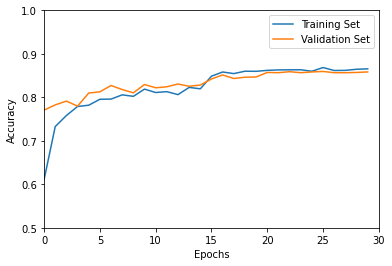

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(epochs), training_accuracy, label = 'Training Set')
plt.plot(np.arange(epochs), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0,epochs])
plt.ylim([0.5,1])
plt.legend()
plt.show()

**Les performances sont légèrement inférieures à celles obtenues avec EfficientNetB0** : on perd 1 à 3 points d'accuracy globale.

In [ ]:
model.save("/content/drive/MyDrive/Leukopy/EfficientNet_B3_TL_11/model_fullsave")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EfficientNet_B3_TL_11/model_fullsave/assets


# Évaluation

Import des poids du modèle :

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/EfficientNet_B3_TL_11/model_fullsave")

## Fonctions

In [8]:
def print_classification_report(testing_set, labels, title):
  """
  Rapport de classification + Matrice de confusion
  """
  # Prédiction : utilise le jeu de test (testing_set)
  predictions = model.predict(testing_set)
  y_pred = tf.argmax(predictions, axis = 1)

  # Calcul et affichage de la matrice de confusion
  cnf_matrix = confusion_matrix(testing_set.classes, y_pred, normalize = 'true')
  classes = range(len(labels))
  
  plt.figure(figsize = (12,12))
  plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
  plt.title("Matrice de confusion - "+title)
  plt.colorbar()

  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), 
                                range(cnf_matrix.shape[1])):
    plt.text(j, i, np.around(cnf_matrix[i, j], decimals = 3),
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()

  # Rapport de classification 
  report = classification_report(testing_set.classes, y_pred, target_names = labels, output_dict = True)

  df_report = pd.DataFrame(index = list(report.keys())[:-3], columns = list(report["BA"].keys()))
  for key in list(report.keys())[:-3]:
    for column in list(report["BA"].keys()):
      df_report.loc[key, column] = report[key][column]
  
  print("Classification Report - "+title)
  return y_pred, display(df_report)

In [9]:
def get_img_array(img_path, size = (img_height, img_width)):
  """
  Importe une image et applique le preprocessing nécessaire à l'utilisation de Xception : batch + preprocess_input
  """
  img_array = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  img_array = tf.keras.preprocessing.image.img_to_array(img_array)
  img_array = np.expand_dims(img_array, axis = 0)
  return img_array

def make_heatmap(img_array, model, last_conv_layer, class_index):
  """
  Calcule la CAM (Class Activation Map) correspondant au label d'indice "class_index" pour l'image "img_array"
  model : un modèle déjà entraîné, dont on désactive la fonction d'activation en sortie (fait dans grandcam())
  last_conv_layer : dernière couche de convolution du modèle. Trouvée automatiquement par la fonction gradcam()
  class_index : renseigné dans l'appel de gradcam() ou trouvé automatiquement par gradcam()
  """
  grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
  
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  # Multiplie chaque carte d'activation par le gradient, puis moyenne
  for i in range(last_conv_layer_output.shape[3]):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)

  return heatmap


def gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.5, plot = True):

  # Désactive softmax sur la dernière couche :
  model.layers[-1].activation = None

  # Détecte la dernière couche de convolution du modèle :
  for layer in reversed(model.layers):
    if 'conv' in layer.name:
      last_conv_layer = model.get_layer(layer.name)
      break

  img_array = get_img_array(img_path, size = (img_height, img_width))

  # Chargement + preprocessing de l'image (conversion, batch, vgg19 special preprocessing):
  if class_index == None :
    # Trouve la classe la plus probable :
    predict = model.predict(img_array)
    class_index = np.argmax(predict[0])

  # Calcul de la CAM : resize pour superposition avec l'image finale
  heatmap = make_heatmap(img_array, model, last_conv_layer, class_index)
  big_heatmap = heatmap

  # Réactive softmax :
  model.layers[-1].activation = tf.keras.activations.softmax

  ## Traitement de la Heatmap
  # Applique ReLu (élimine les valeurs négatives de la heatmap)
  big_heatmap = np.maximum(0, big_heatmap)
  # Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()

  ## Superposition de l'image et de la heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)
  # 3/ Jet colormap
  jet = cm.get_cmap("jet")
  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))

  return big_heatmap, superimposed_img

## Performances : métriques

**Accuracy globale sur le jeu de test :**

In [7]:
model.evaluate(testing_set)

80/80 [==============================] - 29s 142ms/step - loss: 0.3763 - accuracy: 0.8522


[0.3762757480144501, 0.8522012829780579]

On obtient une accuracy globale légèrement inférieure à celle obtenue avec le modèle B0.

**Rapport de classification et matrice de confusion :**

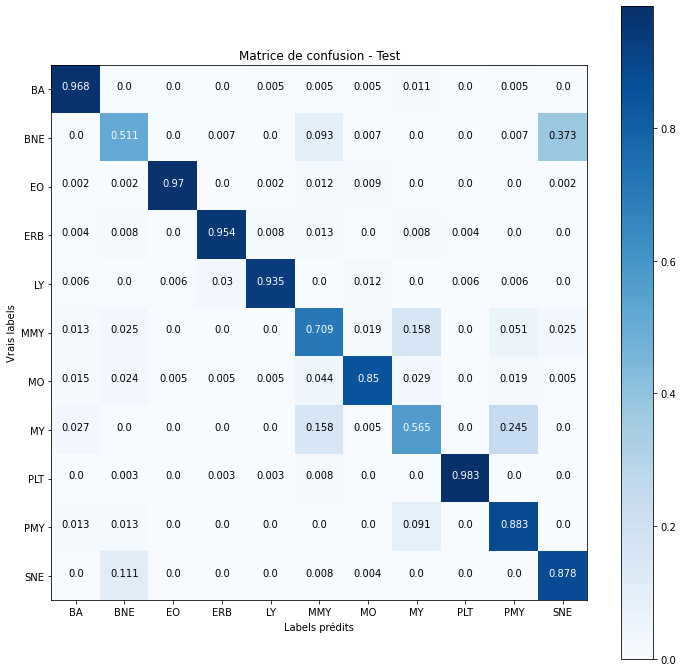

Classification Report - Test


precision    recall  f1-score support
BA   0.928934  0.968254  0.948187     189
BNE  0.761111  0.511194  0.611607     268
EO   0.995249  0.969907  0.982415     432
ERB  0.961702  0.953586  0.957627     237
LY    0.96319  0.934524   0.94864     168
MMY  0.592593  0.708861  0.645533     158
MO   0.925926  0.849515  0.886076     206
MY   0.712329  0.565217  0.630303     184
PLT  0.994429  0.983471   0.98892     363
PMY  0.527132  0.883117  0.660194      77
SNE  0.684524  0.877863  0.769231     262

In [10]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

C'est **assez comparable à ce qu'on avait obtenu avec le modèle B0**. On observe **toujours les mêmes points forts** (EO, ERB, PLT, LY, BA) et **les mêmes points faibles** (la lignée des neutrophiles).

In [11]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

## Performances : Grad-CAM

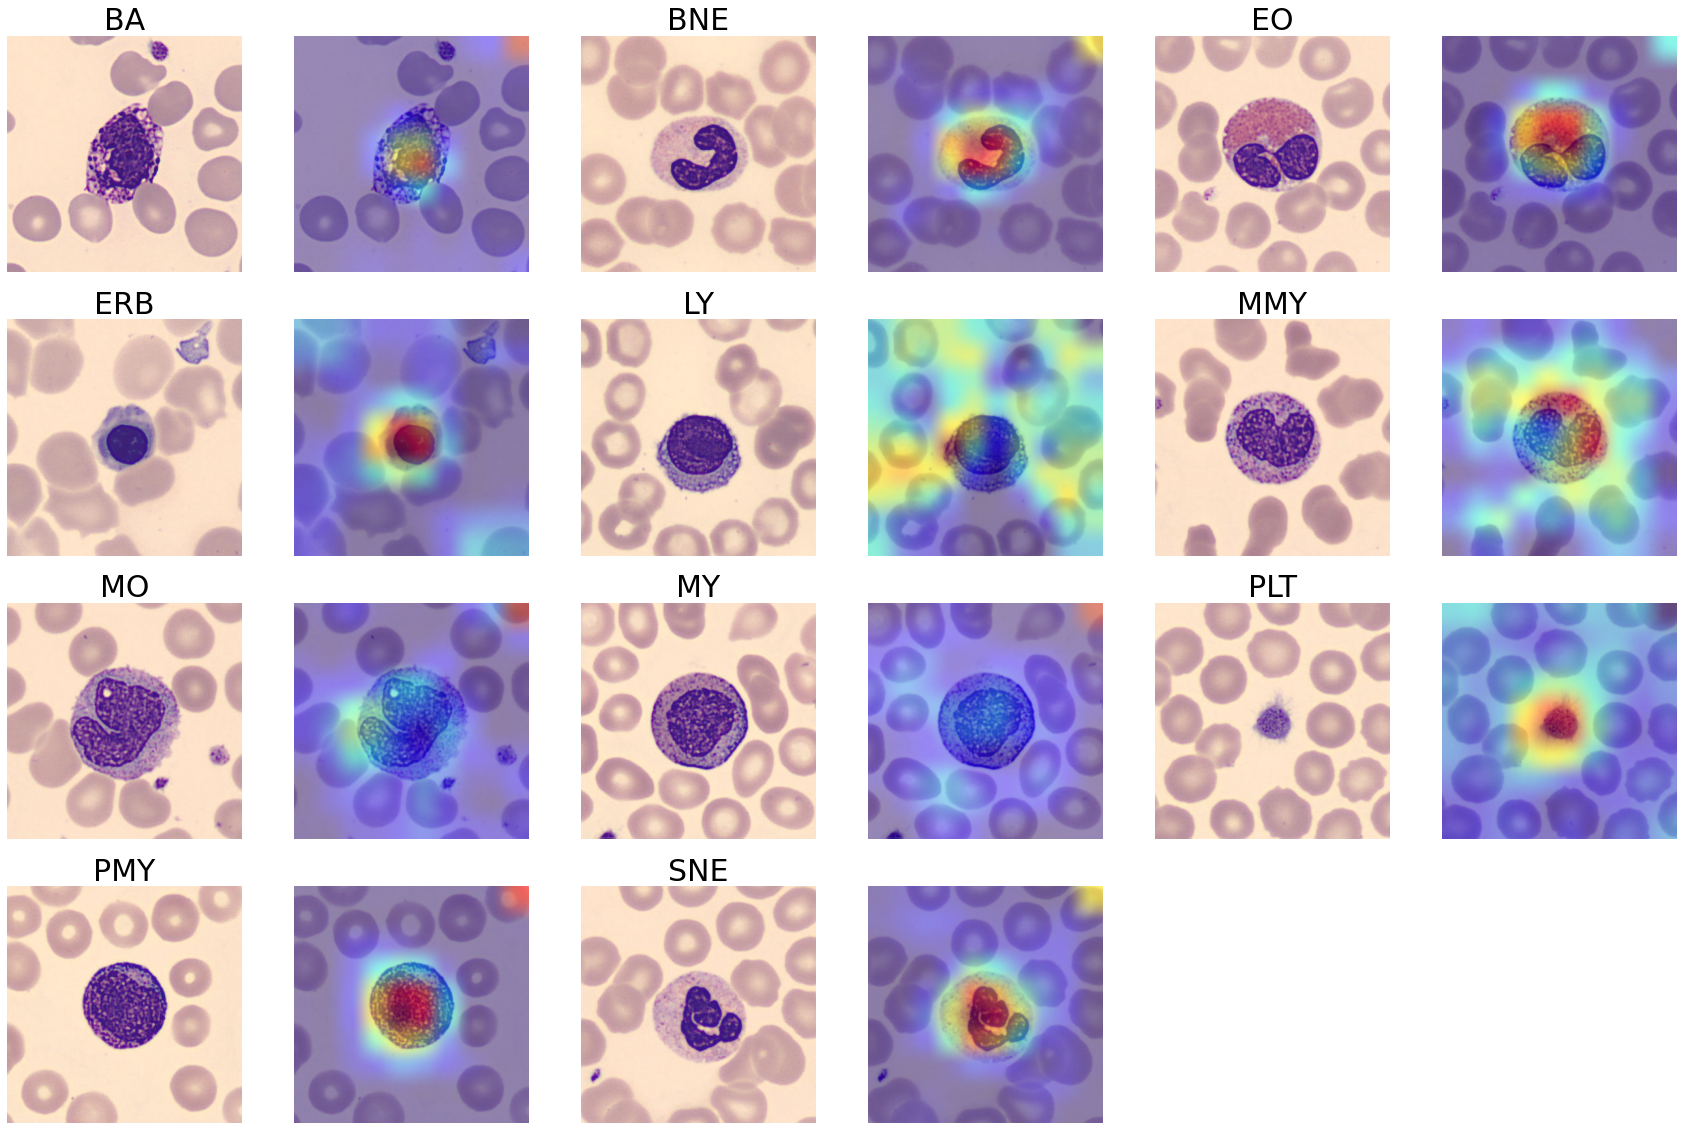

In [ ]:
fig = plt.figure(figsize = (30, 20))
i = 0

for cell_class in range(n_classes):
  df_temp = df_results[(df_results["label"] == cell_class) & (df_results["well_classified"] == True)]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_temp.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(4,6,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(4,6,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

plt.savefig("/content/drive/MyDrive/Leukopy/models/efficientnet_b3/b3_gcam1")

In [12]:
fig = plt.figure(figsize = (30, 20))
i = 0

for cell_class in range(n_classes):
  df_temp = df_results[(df_results["label"] == cell_class) & (df_results["well_classified"] == True)]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_temp.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(4,6,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(4,6,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

plt.savefig("/content/drive/MyDrive/Leukopy/models/efficientnet_b3/b3_gcam2")

Output hidden; open in https://colab.research.google.com to view.

Commentons les cartes thermiques obtenues grâce à Grad-CAM :
- **le modèle semble souvent se focaliser sur la cellule d'intérêt, ou sur des éléments de celle-ci** (granules roses des éosinophiles, noyau pour SNE et BNE) ;

- **parfois, le modèle semble prendre en compte des éléments externes** à la cellule ; de façon plus générale, on soulignera un **manque de régularité dans la qualité des CAM** pour une classe donnée (les deux images de lymphocytes présentées ci-dessus, ou encore les ERB représentées ci-dessous).

- on remarquera la **présence d'un artefact dans le coin supérieur droit** de l'image : un tel artefact est présent sur plusieurs publications scientifiques dans lesquelles le modèle EfficientNet est utilisé ;


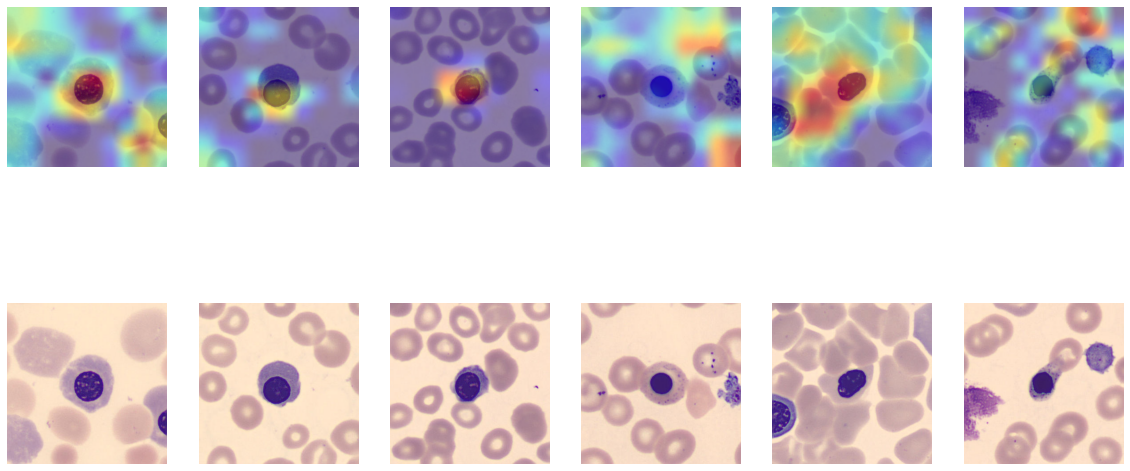

In [21]:
df_ERB = df_results[(df_results["label"] == 3) & (df_results["well_classified"] == True)]

fig = plt.figure(figsize = (20,10))

for i in range(6):
  idx = np.random.choice(a = df_ERB.index)
  img_path = df_ERB.loc[idx,"img_path"]

  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, class_index = None, alpha = 0.8, plot = False)

  plt.subplot(2,6,i+1)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  plt.subplot(2,6,i+7)
  plt.imshow(plt.imread(img_path))
  plt.grid(None)
  plt.axis('off')

Dans l'ensemble, et malgré des défauts évidents, **EfficientNetB3 fait mieux que le modèle B0 du point de vue de Grad-CAM**.

# Conclusion sur EfficientNetB3 avec Transfer Learning :

Malgré des performances métriques légèrement plus faibles qu'EfficientNetB0, **on obtient des class activation map ayant plus de sens avec la version B3 du modèle**. **On va donc privilégier B3 à B0**, pour lequel les résultats de Grad-CAM étaient médiocres.

D'un point de vue purement métrique, **la version B3 semble moins performante que LeNet, ce qui paraît surprenant**. En réalité, **B3 est bien plus complexe, bien plus profond que LeNet : il comporte 390 couches**, dont 385 constituent le modèle EfficientNetB3 proprement dit (contre environ 240 pour le modèle EfficientNetB0) : les couches d’EfficientNetB3 les plus éloignées de l’input sont hautement spécialisées sur le dataset ImageNet, qui comporte plusieurs millions d’images réparties en 1000 classes (animaux, fleurs, véhicules etc…). **Nous importons les poids optimisés pour ImageNet, mais ils ne sont pas optimisés pour notre jeu de données qui ne contient “que” 11 classes de cellules sanguines, images qui n'ont pas grand chose à voir** avec la quasi-totalité des classes d'ImageNet.

**La question se pose d’entraîner la totalité d’EfficientNetB3 pour en tirer pleinement profit.**


# EfficientNetB3 - Entraînement complet

## Modèle et entraînement

In [ ]:
inputs = layers.Input(shape = (img_height,img_width,3))
base_model = EfficientNetB3(include_top = False,
                           weights = None,
                           input_shape = (img_height,img_width,3),
                           input_tensor = inputs,
                           pooling = 'avg')
base_output = base_model.output
x = layers.Dense(units = 1280, activation = 'relu', name = 'dense_1')(base_output)
x = layers.Dropout(rate = 0.2, name = 'dropout_1')(x)
x = layers.Dense(units = 640, activation = 'relu', name = 'dense_2')(x)
x = layers.Dropout(rate = 0.2, name = 'dropout_2')(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax', name = 'final_softmax')(x)
model = tf.keras.Model(inputs, outputs)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model.compile(optimizer = optimizer, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [ ]:
# Callbacks
TON = TerminateOnNaN()

save_model = ModelCheckpoint(filepath = '/content/drive/MyDrive/Leukopy/EfficientNetModelB3_FullTrained/model_trainingsave', 
                             monitor = 'val_loss', 
                             save_best_only = True,
                             save_weights_only = False,
                             save_freq = 'epoch')

control_lr = ReduceLROnPlateau(monitor = 'val_loss',
                               factor = 0.1, patience = 3, verbose = 1, mode = 'min', min_lr = 1e-6)
  
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5, mode = 'min', restore_best_weights = True)

callbacks_list = [TON, control_lr, early_stopping]
                    
## Compute weights :
class_weights = compute_weights(method = 3)

## Training :
epochs = 100
history = model.fit(x = training_set, 
                    epochs = epochs,
                    callbacks = callbacks_list, 
                    validation_data = validation_set, 
                    class_weight = class_weights)

Epoch 1/100
397/397 [==============================] - 379s 918ms/step - loss: 8.8004 - accuracy: 0.4836 - val_loss: 12.4952 - val_accuracy: 0.1422
Epoch 2/100
397/397 [==============================] - 364s 916ms/step - loss: 5.4816 - accuracy: 0.6781 - val_loss: 0.8449 - val_accuracy: 0.7012
Epoch 3/100
397/397 [==============================] - 361s 908ms/step - loss: 4.4687 - accuracy: 0.7425 - val_loss: 3.7071 - val_accuracy: 0.4358
Epoch 4/100
397/397 [==============================] - 362s 911ms/step - loss: 3.7362 - accuracy: 0.7785 - val_loss: 7.3270 - val_accuracy: 0.2850
Epoch 5/100
397/397 [==============================] - 363s 913ms/step - loss: 3.0691 - accuracy: 0.8206 - val_loss: 3.0204 - val_accuracy: 0.5098

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/100
397/397 [==============================] - 363s 913ms/step - loss: 2.3454 - accuracy: 0.8607 - val_loss: 0.3007 - val_accuracy: 0.8798
Epoch 7/100
397/397 [==============

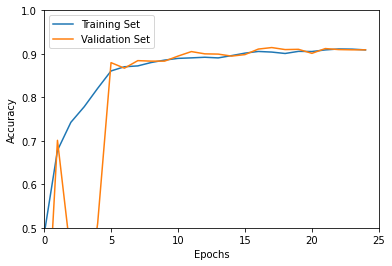

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(25), training_accuracy, label = 'Training Set')
plt.plot(np.arange(25), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim([0,25])
plt.ylim([0.5,1])
plt.legend()
plt.show()

On observe une **très nette amélioration** des performances du modèle : **+5%** d'accuracy globale environ, et l'**absence de surapprentissage**.

In [ ]:
## Sauvegarde :
model.save("/content/drive/MyDrive/Leukopy/EfficientNetModelB3_FullTrained/fulltrain_fullsave")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Leukopy/EfficientNetModelB3_FullTrained/fulltrain_fullsave/assets


## Évaluation

Import des poids :

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Leukopy/EfficientNetModelB3_FullTrained/fulltrain_fullsave")

### Performances : métriques

Accuracy globale sur le jeu de test :

In [23]:
model.evaluate(testing_set)

80/80 [==============================] - 13s 139ms/step - loss: 0.2411 - accuracy: 0.9025


[0.2410687357187271, 0.902515709400177]

L'**absence de surapprentissage** est confirmée par l'évaluation sur le jeu de test.

Rapport de classification & matrice de confusion :

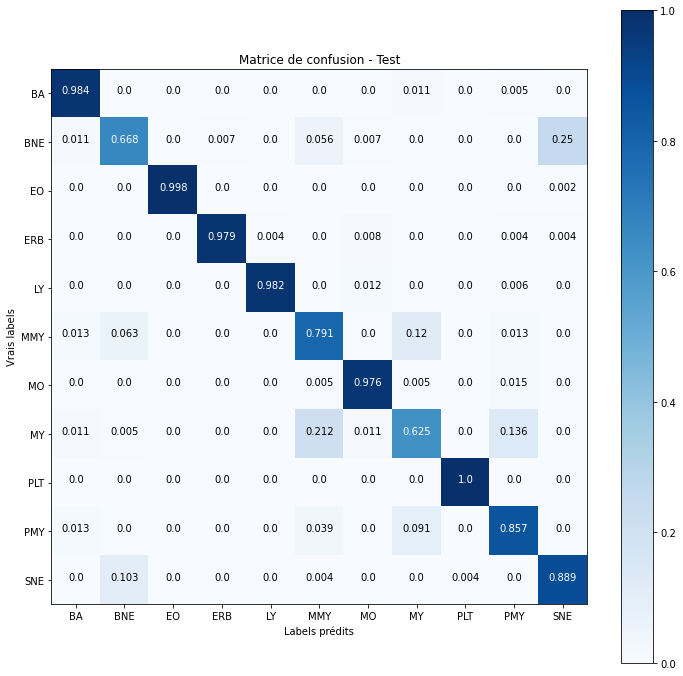

Classification Report - Test


precision    recall  f1-score support
BA   0.958763  0.984127  0.971279     189
BNE  0.824885   0.66791  0.738144     268
EO          1  0.997685  0.998841     432
ERB  0.991453  0.978903  0.985138     237
LY   0.993976  0.982143  0.988024     168
MMY  0.679348  0.791139  0.730994     158
MO   0.961722  0.975728  0.968675     206
MY   0.798611     0.625   0.70122     184
PLT  0.997253         1  0.998624     363
PMY  0.666667  0.857143      0.75      77
SNE  0.771523  0.889313  0.826241     262

In [24]:
y_pred, df_report = print_classification_report(testing_set, label_map, title = "Test")

Le modèle fait bien mieux que LeNet, et ce pour toutes les classes, en particulier celles qui étaient difficiles à classer (BNE, MMY, MY, PMY, SNE). Plusieurs classes franchissent le seuil des 96%, mais la performance sur les neutrophiles reste très moyenne.


Les confusions commises par le modèle sont les mêmes que celles observées avec LeNet : le modèle semble confondre entre elles les sous-classes de neutrophiles : essentiellement BNE vs SNE d’une part, et MY/MMY et PMY d’autre part, mais on retrouve cette notion de confusion avec le stade d’évolution ultérieur ou antérieur qui apparaît nettement dans la matrice de confusion.

In [25]:
df_results = pd.DataFrame(data = {"label":testing_set.classes,
                                  "label_pred":y_pred, 
                                  "img_path":df_test["img_path"]})

df_results["well_classified"] = np.where(df_results["label"] == df_results["label_pred"], True, False)

### Performances : Grad-CAM

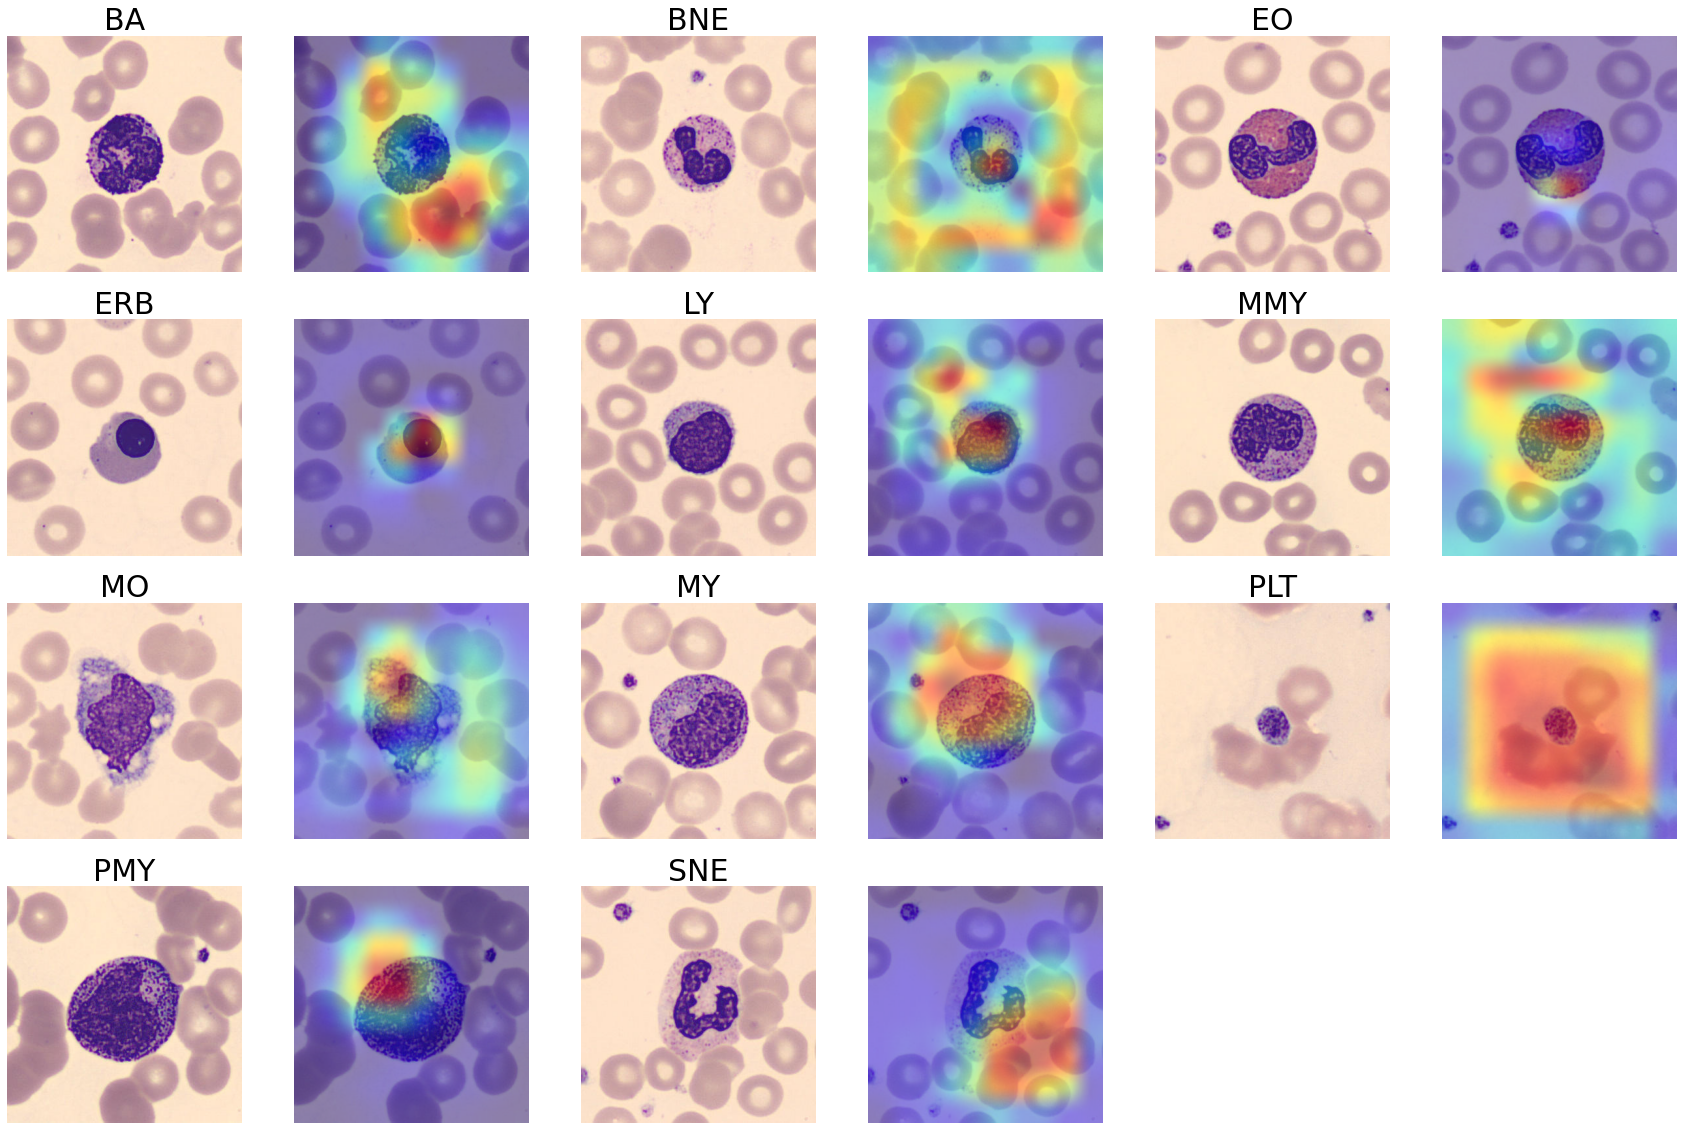

In [ ]:
fig = plt.figure(figsize = (30, 20))
i = 0

for cell_class in range(n_classes):
  df_temp = df_results[(df_results["label"] == cell_class) & (df_results["well_classified"] == True)]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_temp.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(4,6,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(4,6,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

plt.savefig("/content/drive/MyDrive/Leukopy/models/efficientnet_b3/b3_fullytrained_gcam1")

In [26]:
fig = plt.figure(figsize = (30, 20))
i = 0

for cell_class in range(n_classes):
  df_temp = df_results[(df_results["label"] == cell_class) & (df_results["well_classified"] == True)]
  id = np.random.choice(df_temp.index, size = 1, replace = False)
  img_path = df_temp.loc[id[0],"img_path"]
 
  big_heatmap, superimposed_img = gradcam(model, img_path, img_height, img_width, 
                                          class_index = None, alpha = 0.8, plot = False)

  fig.add_subplot(4,6,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(list(label_map.keys())[cell_class], fontsize = 30)
  plt.grid(None)
  plt.axis('off')

  fig.add_subplot(4,6,i+2)
  plt.imshow(superimposed_img)
  plt.grid(None)
  plt.axis('off')

  i += 2

plt.savefig("/content/drive/MyDrive/Leukopy/models/efficientnet_b3/b3_fullytrained_gcam2")

Output hidden; open in https://colab.research.google.com to view.

Le modèle a été entraîné intégralement, et si nous avons gagné du point de vue des métriques, **nous perdons en termes d'interprétabilité et de pertinence des features extraites par EfficientNet** par rapport au cas du transfer learning.

Le modèle a du mal à se focaliser, voire même à trouver, la cellule au centre de l'image. La carte thermique est parfois inexplicable (cas des plaquettes ou des métamyélocytes).

Il ressort de tout ceci qu'EfficientNet semble avoir besoin d'une base de données de taille importante pour s'entraîner correctement : c'était le cas avec ImageNet, ça ne l'est visiblement plus avec Barcelone.

On pourrait essayer le fine-tuning des dernières couches d'EfficientNet dans le cadre du transfer learning depuis ImageNet, mais il est complexe du fait de la structure du modèle et du nombre important de couches qu'il comporte.** Nous avons écarté cette option en faveur de VGG**, qui produit dès le départ (simple transfer learning) des class activation map de meilleure qualité et des performances métriques intéressantes.